# Визуализация

Данный Kernel стал результатом воспроизведения <a href="https://www.kaggle.com/yellowduck/baseline-in-pytorch">baseline</a> от <a href="https://www.kaggle.com/yellowduck">Игоря Слинько</a>, и попытки следовать <a href="http://karpathy.github.io/2019/04/25/recipe/">советам</a> по обучению нейронных сетей <a href="https://twitter.com/account/access">Андрея Корпатого</a>.

Основной идеей данного решения являлось создать каркас обучения, с визуализацией каждого этапа. 

Визуализация позволяет глубже понять изменение повеения модели при ее модификации. При таком подходе небохдимо аккуратно вносить изменения в модель, по одному за раз.

-------------------------------------------------------------------------------------------------------------------------------------------------------

## TODO:
* Аугментации (см. дневник)
* Манипуляции с моделью
* Планировщик
* Манипуляции с размером батча
* Манипуляции с l2 регуляризацией
* Манипуляции с видом градиентного спуска
* Early stopping

---

# 1. Подготовка

## 1.1 Фиксируем генераторы случайных чисел

Для воспроизводимости результатов необходимо зафиксировать все генераторы случайных чисел.

In [26]:
import numpy as np 
import pandas as pd 
import random
import torch
import os

random.seed(97)
np.random.seed(97)
torch.manual_seed(97)
torch.cuda.manual_seed(97)
torch.backends.cudnn.deterministic = True

## 1.2 Задаем параметры обучения сети

Расположение данных

In [27]:
# Путь к исходной обучающей выборке
PATH_TO_TRAIN = './input/plates/plates/train'
# Путь к аугментированной исходной обучающей выборке
PATH_TO_AUG = './input/plates/plates/aug'
# Путь к тестовой выборке
PATH_TO_TEST = './input/plates/plates/test'
# Путь к выборке, на которой будет обучаться модель
TRAIN_DIR = 'train'
# Путь к выборке, на которой будет оцениваться качество модели
VAL_DIR = 'val'
# Путь к тестовой выборки
TEST_DIR = 'test'

Имена классов

In [28]:
labels = ['cleaned', 'dirty']

Параметры обучения

In [29]:
# использовать аугментации, порождаемые блокнотом augmentations
use_custom_augmentations = True

# Кол-во примеров из обучающей выборки, после которых делается градиентный шаг
batch_size = 20

# Скорость обучения нейронной сети
lr = 3e-4

# Штраф L2 регуляризации
l2_regularization = 5e-2
# Использовать l2 регуляризацию
l2_enabled = True

# Использовать Dropout
dropout_enabled = False
# шанс, что выход будет занулён
dropout_p = 0.1

# Кол-во эпох обучения
num_epoch = 70

# Если выход сети больше этого значения, то считаем тарелку грязной
dirty_split = 0.5

# каждое valid_split изображение обучающей выборки будет отложено для валидаионной выборки
valid_split = 50

Параметры lr_scheduler.StepLR

In [30]:
# Кол-во эпох, после которого уменьшается lerning rate
step_size = 20
gamma=0.2
# использовать планировщик
use_scheduler = True

Параметры всего kernel

In [31]:
# вывод прогресса обучения
show_progress = True
# вывод изображений для обучения
show_input = True
# количество батчей, которое нужно вывести перед обучением
batchs_to_show = 1
# telegram token & chat_id для уведомления
token = "input your token here"
my_id = -1 # input your own chat id here
# уведомлять владельца по telegram об успешном выполнении
notify_owner = False

## 1.3 Изучаем исходные данные

In [32]:
from PIL import Image
from random import sample
from os.path import join
from os import listdir
import matplotlib.pyplot as plt

Визуализация обучающей выборки

cleaned


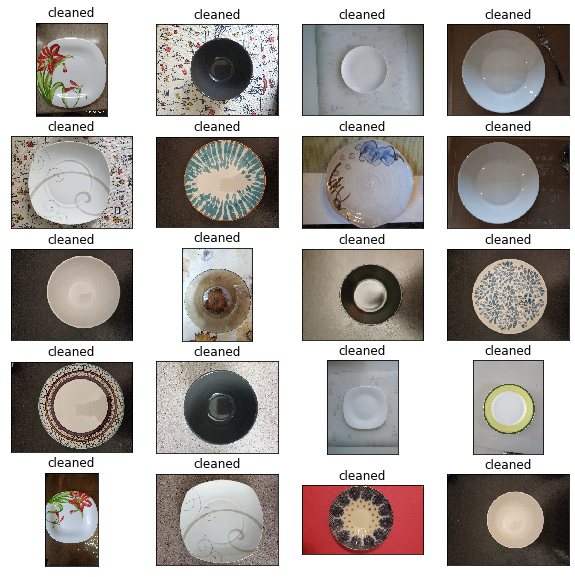

dirty


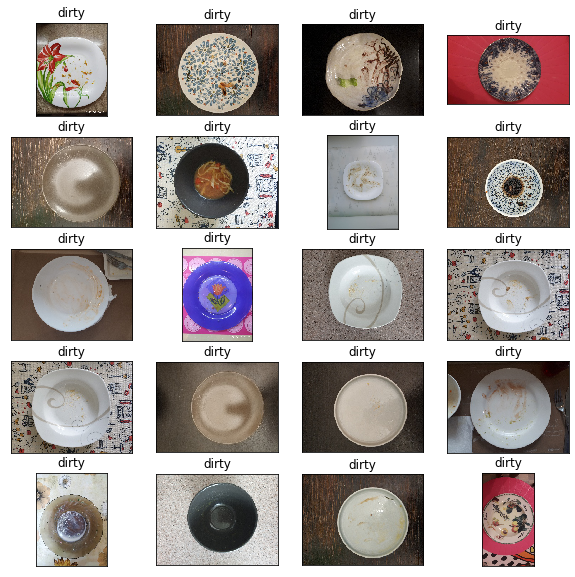

In [33]:
if show_input:
    for label in labels:
        print(label)
        # Путь к обучающим данным класса label
        PATH = join(PATH_TO_TRAIN, label)
        # Кол-во изображений в данной папке
        n = len(listdir(PATH))
        plt.figure(figsize=(10, 10))
        for i,image in enumerate(listdir(PATH)):
            plt.subplot(n/4, 4, i+1)
            img = Image.open(join(PATH,image))
            plt.imshow(img)
            plt.title(label)
            plt.xticks([])
            plt.yticks([])
        plt.show()

Визуализация части тестовой выборки

Test set


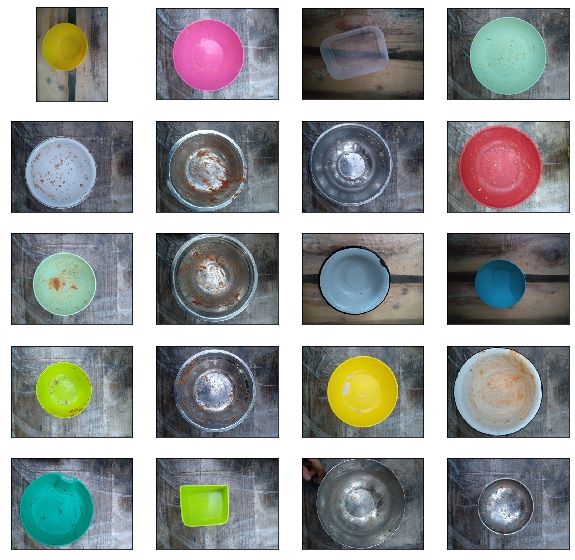

In [34]:
if show_input:
    n_samples = 20
    # Выбираем случайные 20 изображенй из тестовой выборки
    sub_sample = sample(listdir(PATH_TO_TEST), n_samples)
    plt.figure(figsize=(10, 10))
    print('Test set')
    for i,image in enumerate(sub_sample):
        plt.subplot(n_samples/4, 4, i+1)
        img = Image.open(join(PATH_TO_TEST, image))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

## 1.4 Подготовка данных. Разделение на обучающую и  валидационную выборку

In [35]:
from shutil import copy
from os import makedirs

Разделим исходную обучающую выборку на **обучающаю** и **валидационную**. Для этого создадим папки `train` и `val` и в каждой из них создадим папки `cleaned` и `dirty`.

In [36]:
for dir_name in [TRAIN_DIR, VAL_DIR]:
    for label in labels:
        makedirs(join(dir_name, label),
                exist_ok=True)

Будем класть каждое `valid_split` по счету изображение из исходной обучающей выборки в валидационную выборку (в папку `val`), остальные изображения будут скопированны в папку `train`.
В случае своих дополнительных аугментаций, возьмём часть изображений из `path-to-train`, запомним, остальные возьмём из `path-to-aug`

In [37]:
if not use_custom_augmentations:
    for label in labels:

        # Папка из которой будем копировать файлы 
        source_dir = join(PATH_TO_TRAIN, label)

        for i, file_name in enumerate(listdir(source_dir)):

            # Выбираем куда скопировать файл
            if i % valid_split != 0:
                dest_dir = join(TRAIN_DIR, label)
            else:
                dest_dir = join(VAL_DIR, label)

            # Копируем файл в выбранную папку
            copy(
                join(source_dir, file_name),
                join(dest_dir, file_name)
            )
else:
    for label in labels:
        # нужен для запоминания использованных имён
        validation_set = set()
        validation_source_dir = join(PATH_TO_TRAIN, label)
        
        for index, file_name in enumerate(listdir(validation_source_dir)):
            if index % valid_split == 0:
                dest_dir = join(VAL_DIR, label)
                copy(
                    join(validation_source_dir, file_name),
                    join(dest_dir, file_name)
                )
                validation_set.add(file_name[:4])
                
        train_source_dir = join(PATH_TO_AUG, label)
        
        for index, file_name in enumerate(listdir(train_source_dir)):
            if file_name[:4] not in validation_set:
                dest_dir = join(TRAIN_DIR, label)
                copy(
                    join(train_source_dir, file_name),
                    join(dest_dir, file_name)
                )

## 1.5. Аугментация данных

Задаем последовательность преобразований изображений для увеличения разнообразия изображений.

In [38]:
from torchvision import transforms 

In [39]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter()
    ]),
    transforms.RandomApply([
        transforms.RandomGrayscale()
    ]),
#     transforms.RandomRotation(30),
    transforms.RandomChoice([
#         transforms.Compose([
#             transforms.CenterCrop(224)
#         ]),
        transforms.Compose([
            transforms.RandomResizedCrop(224)
        ]) #,
#         transforms.Compose([
#             transforms.RandomPerspective(),
#             transforms.Resize((224, 224))
#         ]),
    ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                          [0.229, 0.224, 0.225])
])

## 1.6 Создание "загрузчиков данных" для обучения и валидации

In [40]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset

In [41]:
# Формирует датасет из избражений лежащих в указанной папке
train_dataset = ImageFolder(TRAIN_DIR, train_transforms)
val_dataset = ImageFolder(VAL_DIR, val_transforms)

In [42]:
# Загружает данные из сформированных ранее датасетов
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=batch_size)

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=batch_size)

## 1.7 Визуализация обучающей выборки

In [43]:
def show_batch(X_batch, y_batch, batch_size):
    plt.figure(figsize=(10, 5))
    for i, (image_tensor, class_index) in enumerate(zip(X_batch, y_batch)):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image_tensor.permute(1, 2, 0).numpy()
        image = std * image + mean
        plt.subplot(batch_size/4, 4, i+1)
        plt.imshow(image)
        plt.title(labels[class_index])
        plt.xticks([])
        plt.yticks([])      
    plt.show()

Batch 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

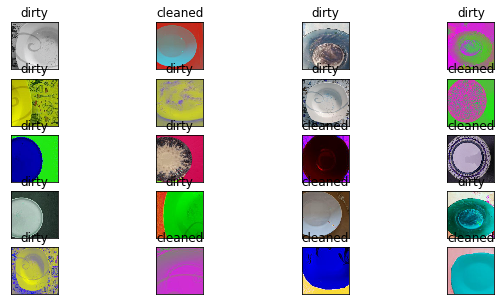

In [44]:
if show_input:
    for i in range(batchs_to_show):
        print('Batch', i+1)
        X_batch, y_batch = next(iter(train_dataloader))
        show_batch(X_batch, y_batch, batch_size)

# 2. Создание нейронной сети

## 2.1. Загрузка базовой модели

In [45]:
# для подсчёта средней скорости обучения
from time import time
from math import trunc

from torchvision import models
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler

In [46]:
class PlatesNet(torch.nn.Module):
    def __init__(self):
        super(PlatesNet, self).__init__()
        self.resnet = models.resnet152(pretrained=True, progress=False)

        # Замораживаем все слои
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
        
        # меняем последний слой предобученного resneta на свой (свои)
        in_features = self.resnet.fc.in_features
        if dropout_enabled:
            self.resnet.fc = torch.nn.Dropout(p=dropout_p)
            self.final_layer = torch.nn.Linear(in_features, 2)
        else:
            self.resnet.fc = torch.nn.Linear(in_features, 2)
    
    def forward(self, X):
        X = self.resnet(X)
        
        if dropout_enabled:
            X = self.final_layer(X)
        
        return X

model = PlatesNet()

# Перекладываем вычисления на GPU
# в случае ее отсутствия на CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("move to {}".format("gpu" if torch.cuda.is_available() else "cpu"))

move to gpu


In [47]:
# Задаем функцию потерь
loss = CrossEntropyLoss()

In [48]:
# Задаем оптимизатор
if l2_enabled:
    optimizer = Adam(model.parameters(),
                     lr=lr, weight_decay=l2_regularization)
else:
    optimizer = Adam(model.parameters(),
                     lr=lr)

In [49]:
scheduler = lr_scheduler.StepLR(optimizer,
                                step_size=step_size,
                                gamma=gamma)

## 2.2. Дообучение нейронной сети

In [50]:
def train_model(model,
                loss,
                optimizer,
                scheduler,
                num_epochs):
    # время начала обучения
    start_training_time = time()
    
    # Будем записывать промежуточные результаты
    # для дальнейшей визуализации обучения
    train_accuracy_history = []
    train_loss_history = []
    val_accuracy_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        if show_progress == True:
            print()
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # На каждой эпохе будем сначала обучать сеть
        # затем проверять ее качество на валидационной выборке
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()
        
            running_loss = 0
            running_acc = 0
            
            # Загружаем данные и
            # и обнуляем градиент
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # На фазе обучения делаем вычисляем ошибку 
                # на тестовой выборке и делаем градиентный шаг
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                running_loss += loss_value.data.cpu()
                running_acc += (preds_class == labels.data).float().mean().data.cpu()
            
            # Средня ошибка и точность на эпохе
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
        
            # Запоминаем значения ошибки и точности 
            # для дальнейшей визуализации
            if phase == 'train':
                train_accuracy_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            
            if show_progress == True:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    
        if show_progress == True:
            speed = (epoch + 1) / (time() - start_training_time)
            time_in_seconds = trunc((num_epochs - epoch) / speed)
            print('Speed: {} epoch / s'.format(speed))
            print('Time remaining {} m {} s'.format(time_in_seconds // 60, time_in_seconds % 60))
            
    return train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history

In [51]:
history = train_model(model,
                      loss,
                      optimizer,
                      scheduler,
                      num_epochs=num_epoch);


Epoch 0/69:


/home/ls/anaconda3/envs/ml/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.3344 Acc: 0.8342
val Loss: 0.0027 Acc: 1.0000
Speed: 0.06046402705201497 epoch / s
Time remaining 19 m 17 s

Epoch 1/69:
train Loss: 0.2171 Acc: 0.9158
val Loss: 0.0715 Acc: 1.0000
Speed: 0.06140574141304632 epoch / s
Time remaining 18 m 43 s

Epoch 2/69:
train Loss: 0.2224 Acc: 0.8974
val Loss: 0.1396 Acc: 1.0000
Speed: 0.06174441382854894 epoch / s
Time remaining 18 m 21 s

Epoch 3/69:
train Loss: 0.1611 Acc: 0.9289
val Loss: 1.4131 Acc: 0.5000
Speed: 0.061855466146793964 epoch / s
Time remaining 18 m 3 s

Epoch 4/69:
train Loss: 0.1855 Acc: 0.9237
val Loss: 0.7409 Acc: 0.5000
Speed: 0.0618947237318072 epoch / s
Time remaining 17 m 46 s

Epoch 5/69:
train Loss: 0.1368 Acc: 0.9579
val Loss: 4.6165 Acc: 0.5000
Speed: 0.06191377277497305 epoch / s
Time remaining 17 m 29 s

Epoch 6/69:
train Loss: 0.1295 Acc: 0.9421
val Loss: 1.6148 Acc: 0.5000
Speed: 0.06190296200186104 epoch / s
Time remaining 17 m 13 s

Epoch 7/69:
train Loss: 0.1618 Acc: 0.9316
val Loss: 0.0131 Acc: 1.0

train Loss: 0.0393 Acc: 0.9895
val Loss: 0.5925 Acc: 0.5000
Speed: 0.062236648401447665 epoch / s
Time remaining 2 m 24 s

Epoch 62/69:
train Loss: 0.0358 Acc: 0.9868
val Loss: 0.6252 Acc: 0.5000
Speed: 0.06224049272227228 epoch / s
Time remaining 2 m 8 s

Epoch 63/69:
train Loss: 0.0351 Acc: 0.9868
val Loss: 0.6589 Acc: 0.5000
Speed: 0.06224389273450357 epoch / s
Time remaining 1 m 52 s

Epoch 64/69:
train Loss: 0.0382 Acc: 0.9842
val Loss: 0.5657 Acc: 0.5000
Speed: 0.06223911056013427 epoch / s
Time remaining 1 m 36 s

Epoch 65/69:
train Loss: 0.0277 Acc: 0.9921
val Loss: 0.7447 Acc: 0.5000
Speed: 0.06224394250443205 epoch / s
Time remaining 1 m 20 s

Epoch 66/69:
train Loss: 0.0433 Acc: 0.9868
val Loss: 0.6160 Acc: 0.5000
Speed: 0.06224407008217986 epoch / s
Time remaining 1 m 4 s

Epoch 67/69:
train Loss: 0.0336 Acc: 0.9842
val Loss: 0.7382 Acc: 0.5000
Speed: 0.062239385245068536 epoch / s
Time remaining 0 m 48 s

Epoch 68/69:
train Loss: 0.0576 Acc: 0.9842
val Loss: 0.7453 Acc: 0.

# 3. Визуализация обучения

In [52]:
from torch import nn

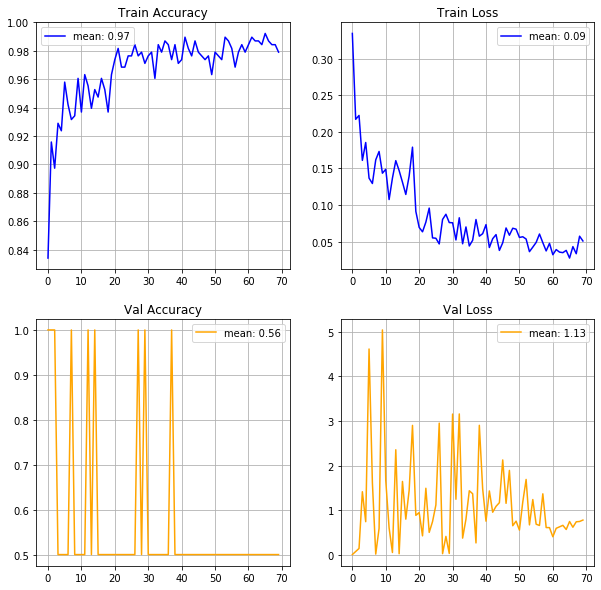

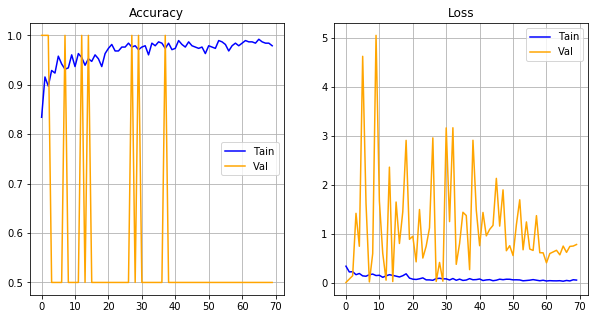

In [53]:
# Рисуем графики  Accuracy и Loss для Тренеровочной и валидационной выборки
titles = ['Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss']
plt.figure(figsize=(10, 10))
for i, image in enumerate(history):
    plt.subplot(2, 2, i+1)
    plt.title(titles[i])
    plt.grid()
    if i == 0 or i == 1:
        color = 'b'
    else:
        color = 'orange'
    plt.plot(image,c=color, label= 'mean: %.2f' % np.array(image).mean())
    plt.legend(loc='best')
plt.show()

# Рисуем совмещенные графики  Accuracy и Loss для Тренеровочной и валидационной выборки
titles_ = ['Accuracy','Loss']
plt.figure(figsize=(10, 5))
k=0
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(history[0+k], label='Tain', c='b')
    plt.plot(history[2+k], label='Val', c='orange')
    plt.title(titles_[i])
    plt.grid()
    plt.legend(loc='best')
    k += 1

/home/ls/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


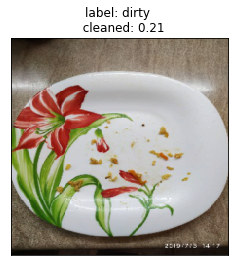

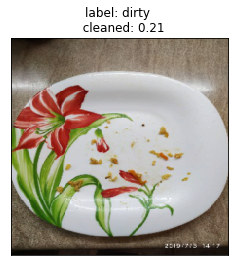

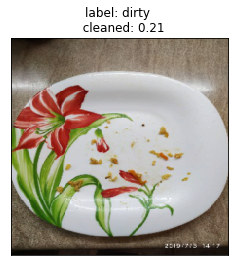

In [54]:
model.eval()

for _ in range(3):
    for inputs, labels_ in val_dataloader:
        inputs = inputs.to(device)
        labels_ = labels_.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        val_predictions = nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
        labels_ = labels_.cpu().numpy()
        predict = val_predictions > dirty_split
        ind = (labels_ == predict)
        for i, image_tensor in enumerate(inputs):
            if ind[i] == False:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = image_tensor.cpu().permute(1, 2, 0).numpy()
                image = std * image + mean
                plt.imshow(image)
                plt.title('label: %s \n  %s: %.2f' % (labels[labels_[i]],
                                                      labels[predict[i]],
                                                      val_predictions[i]))
                                                                   
                plt.xticks([])
                plt.yticks([]) 
                plt.show()
        print()

# 4. Классификация тестовой выборки

In [55]:
from shutil import copytree

In [56]:
# Копируем тестовые изображения 
# в папку 'test/unknown'
# для правильной работы ImageFolder
copytree(PATH_TO_TEST,
         join(TEST_DIR, 'unknown'))

'test/unknown'

In [57]:
from torchvision import transforms, models, datasets

In [58]:
# Модифицируем ImageFolder так, что бы он 
# отображал не только изображение с его меткой, но и
# путь к изображению
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths,self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [59]:
test_dataset = ImageFolderWithPaths(TEST_DIR, val_transforms)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=batch_size)

In [60]:
# Переведем модель в evaluation состояние
# (не будут изменятся параметры сети)
model.eval()

# Предсказания
test_predictions = []
# Пути к изображениям
test_img_paths = []

In [61]:
from tqdm import tqdm
# В цикле полусаем Batch с изображениями, метку класса ('unknown') и пути к изображениям
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        # Считаем предсказания модели
        preds = model(inputs)
    # С помощью softmax приводим их к вероятностям
    # В результате получаем вероятность первого класса ('грязная тарелка')
    test_predictions.append(nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    # Пути нужны для визуализации и созранения предсказаний
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 38/38 [00:23<00:00,  1.61it/s]


## 4.1. Визуализация предсказаний

In [62]:
 prediction = dict(zip(test_img_paths, test_predictions))

Test set


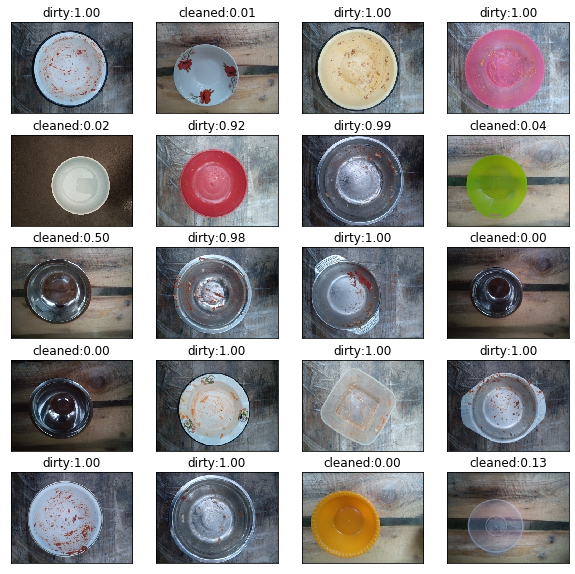

In [63]:
# Визуализация предсказаний классификатора
n_samples = 20
sub_sample = sample(test_img_paths, n_samples)
plt.figure(figsize=(10, 10))
print('Test set')
for i,image in enumerate(sub_sample):
    plt.subplot(n_samples/4, 4, i+1)
    img = Image.open(image)
    plt.imshow(img)
    title = 'dirty' if prediction[image] > dirty_split else 'cleaned'
    title = '%s:%.2f' % (title, prediction[image])
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
plt.show()

# 5. Сохранение предсказаний

In [64]:
# Формируем DataFrame из путей к изображениям и соответствующим им предсказанным классам
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 
                                        'label': test_predictions})

In [65]:
submission_df.head()

,id,label
0,test/unknown/0000.jpg,0.999959
1,test/unknown/0001.jpg,0.998526
2,test/unknown/0002.jpg,0.953989
3,test/unknown/0003.jpg,0.997709
4,test/unknown/0004.jpg,0.411105


In [66]:
# Отчищаем id от лишего, оставляя только номер изображения
# И преобразуем вероятности к классам
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > dirty_split else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head()

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,cleaned


In [67]:
# Сохраняем в csv файл
submission_df.to_csv('submission.csv')

# Удаляем созданные файлы

In [68]:
!rm -rf train val test 

# Уведомляем владельца об успешном выполении блокнота

In [69]:
from bot import notify

In [70]:
message = "notebook finished successfully!\n"
message += "results:\n last 5 train acc. - {} \n last 5 val acc. - {}".format(history[0][-5:], history[1][-5:])
if notify_owner:
    try:
        notify(message, token, my_id)
    except:
        print("ehh, nope..")

sending message to owner


<Response [200]>